In [114]:
# Imports
import pandas as pd
from dotenv import load_dotenv
import os
import csv
import spacy 
import time
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data processing

In [ ]:
load_dotenv()
filepath = os.getenv('FILEPATH')

**Reading the original dataset into Pandas dataframe and splitting the data into train (80), validation (10) and test (10) sets**

In [ ]:

"""
The corpus is formatted as a CSV and contains the following fields:

    id
    domain
    type
    url
    content
    scraped_at
    inserted_at
    updated_at
    title
    authors
    keywords
    meta_keywords
    meta_description
    tags
    summary
    source (opensources, nytimes, or webhose)
"""
csv.field_size_limit(100000000)


selected_columns = ["domain", "title", "authors", "type", "content", "url"]
sample_chunks = []
for chunk in pd.read_csv(filepath, usecols=selected_columns, chunksize=100000, on_bad_lines='warn', engine='python'):
    sample = chunk.sample(frac=0.1, random_state=42)
    sample_chunks.append(sample)
    df = pd.concat(sample_chunks, ignore_index=True)

train_dataframe, temp_dataframe = train_test_split(df, test_size=0.2, random_state=42) # 80% for training and temp for validation and testing
validation_dataframe, test_dataframe = train_test_split(temp_dataframe, test_size=0.5, random_state=42) # splitting the temp data into 10% for validation and 10% for testing

train_dataframe.to_csv("data/train_data.csv", chunksize=100000)
validation_dataframe.to_csv("data/validation_data.csv", chunksize=100000)
test_dataframe.to_csv("data/test_data.csv", chunksize=100000)

**Processing the data using SpaCy nlp library**

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # https://www.geeksforgeeks.org/tokenization-using-spacy-library/
selected_columns = ["domain", "title", "authors", "type", "content", "url"]

# counter info https://www.geeksforgeeks.org/python-counter-objects-elements/
lemmatized_vocab_counter = Counter() # number of lemmatized words without stopwords 
stopword_counter = Counter() 
filtered_vocab_counter = Counter() # number of words without stopwords
original_vocab = set()
csv.field_size_limit(100000000)

# I used chatgpt here for understanding how to use spacy and processing the texts in batches to make the processing more efficient
# spacy docs: https://spacy.io/usage/processing-pipelines 
def preprocess(texts):
    for doc in nlp.pipe(texts, batch_size=500, n_process=4): # batch size is the number of texts to process at once

        for token in doc: # token is a single word/punctuation in a list of tokens
            if token.is_alpha: # check if token is a word
                original_vocab.add(token.text.lower())
                word = token.text.lower()
                if (token.is_stop): # if the token is a stopword, add to counter
                    stopword_counter[word] += 1
                else: # otherwise update the filtered vocab counter and lemmatized vocab counter
                    filtered_vocab_counter[word] += 1
                    lemmatized_vocab_counter[token.lemma_.lower()] += 1 
        
        yield " ".join(token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop)

input_files = ["data/train_data.csv", "data/validation_data.csv", "data/test_data.csv"]
output_files = ["data/processed_train.csv", "data/processed_validation.csv", "data/processed_test.csv"]

for input_file, output_file in zip(input_files, output_files):
    print(f"Processing {input_file}")
    first_chunk = True

    # writing the processed text data into another file
    with open(output_file, "w", encoding="utf-8") as f_out: 
        for chunk in pd.read_csv(input_file, encoding="utf-8", usecols=selected_columns, on_bad_lines='warn', chunksize=1024, engine='python'):
            start = time.time() # timing the chunk processing for debugging

            # adding label column which tells whether the article is reliable (=1) or not (=0)
            chunk["label"] = chunk["type"].apply(lambda x: 1 if str(x).strip().lower() == "reliable" else 0)
            # collecting yields into a list
            texts = chunk["content"].fillna("").astype(str).tolist() # content column to a list
            processed = list(preprocess(texts)) # processing the list
            chunk["processed_text"] = processed # assigning back to chunk

            print(f"Chunk processed in {time.time() - start:.2f}s")
            # appending the chunk to the output file
            chunk[["processed_text", "label", "type", "domain", "title", "url", "authors"]].to_csv(f_out, mode="a", header=first_chunk, index=False) 
            first_chunk = False # for the header 


print("Preprocessing done.")

In [74]:
# Reading the processed csv files into Pandas Dataframes
df_train = pd.read_csv("data/processed/processed_train.csv")  
df_valid = pd.read_csv("data/processed/processed_validation.csv")
df_test = pd.read_csv("data/processed/processed_test.csv")  

### Computing reduction rates

In [ ]:

stats_path = "data/preprocessing_stats.txt"

if os.path.exists(stats_path): # checking if a statistics file already exists, so we don't have to do the analysis again
    print("Preprocessing stats already exist, reading from file\n")
    with open(stats_path, "r", encoding="utf-8") as f:
        print(f.read())
else: 
    original_vocab_size = len(original_vocab) 
    filtered_vocab_size = len(filtered_vocab_counter)
    lemmatized_vocab_size = len(lemmatized_vocab_counter)

    # reduction rate after stopword removal
    stopword_reduction_rate = ((original_vocab_size - filtered_vocab_size) / original_vocab_size) * 100

    # calculating lemmatized reduction rate
    lemmatized_reduction_rate = ((filtered_vocab_size - lemmatized_vocab_size) / filtered_vocab_size) * 100

    print(f"Original vocabulary size: {original_vocab_size}")
    print(f"Vocabulary size after removing stopwords: {filtered_vocab_size}")
    print(f"Vocabulary size after lemmatization: {lemmatized_vocab_size}")
    print(f"Stopword reduction rate: {stopword_reduction_rate:.2f}%")
    print(f"lemmatized reduction rate: {lemmatized_reduction_rate:.2f}%")

    with open("data/preprocessing_stats.txt", "w", encoding="utf-8") as f:
        f.write(f"Original vocabulary size: {original_vocab_size}\n")
        f.write(f"Vocabulary size after removing stopwords: {filtered_vocab_size}\n")
        f.write(f"Vocabulary size after lemmatization: {lemmatized_vocab_size}\n")
        f.write(f"Stopword reduction rate: {stopword_reduction_rate:.2f}%\n")
        f.write(f"Lemmatized reduction rate: {lemmatized_reduction_rate:.2f}%\n")

    



In [53]:
print(df_train.head(10)) 

                                      processed_text  label        type  \
0  times cover widely regard major american fashi...      1    reliable   
1  dear reader excited announce voice russia chan...      0        bias   
2     late deliver daily friend think read newspaper      0   political   
3  receive natural health newsletter free subscri...      0     junksci   
4  break tradition budget year yes go deliver fal...      0      satire   
5  mark twain describe foul vilest obscene pictur...      0   political   
6  tor tor encrypt anonymise network make hard in...      0  unreliable   
7  tor tor encrypt anonymise network make hard in...      0  unreliable   
8  edit reason give find little concern fact apri...      0  conspiracy   
9  боевики обстреляли дагестанских омоновцев неиз...      0        bias   

               domain                                              title  \
0         nytimes.com  Gösta Peterson, Barrier-Breaking Fashion Photo...   
1     sputniknews.com 

### Exploring training data after preprocessing

**Precentage distribution of labels in the dataset**

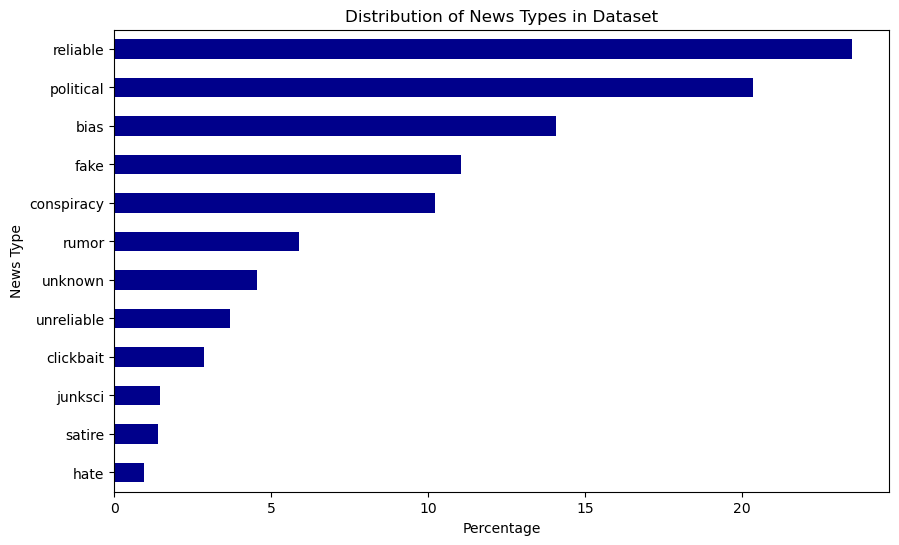

In [36]:
type_distribution = df_train["type"].value_counts(normalize=True) * 100 # counting the distribution
type_distribution.sort_values().plot(kind="barh", figsize=(10, 6), color="darkblue") # plotting a horizontal bar

plt.xlabel("Percentage")
plt.ylabel("News Type")
plt.title("Distribution of News Types in Dataset")
plt.show()

**Visualizing the distribution of words in reliable vs non-reliable news**

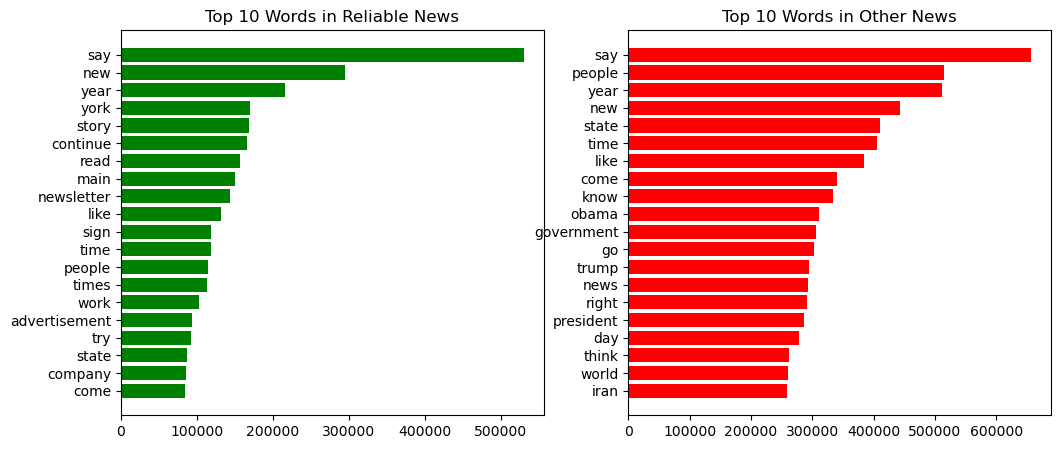

In [40]:
reliable_texts = df_train[df_train["label"] == 1]["processed_text"].dropna().astype(str)
other_texts = df_train[df_train["label"] != 1]["processed_text"].dropna().astype(str)

reliable_counter = Counter()
for text in reliable_texts:
    reliable_counter.update(text.split())

other_counter = Counter()
for text in other_texts:
    other_counter.update(text.split())

# counting the top 10 words in reliable and other news
reliable_top10 = reliable_counter.most_common(20)
other_top10 = other_counter.most_common(20)

# unzipping the word and count pairs
words_r, counts_r = zip(*reliable_top10) # https://www.w3schools.com/python/ref_func_zip.asp
words_o, counts_o = zip(*other_top10)

plt.figure(figsize=(12, 5))

# Plot reliable
plt.subplot(1, 2, 1)
plt.barh(words_r[::-1], counts_r[::-1], color="green")
plt.title("Top 10 Words in Reliable News")

# Plot other
plt.subplot(1, 2, 2)
plt.barh(words_o[::-1], counts_o[::-1], color="red")
plt.title("Top 10 Words in Other News")

plt.show()


**Average and median text lengths by news label (fake or reliable)**

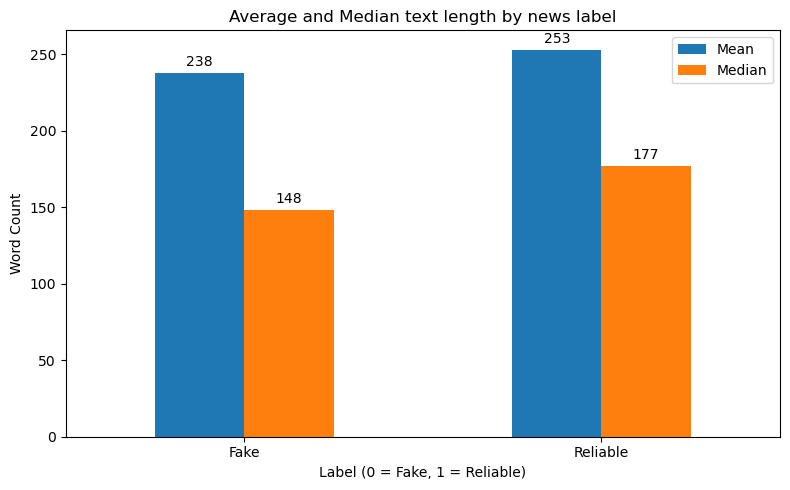

In [41]:
avg_md_stats = df_train.groupby("label")["text_length"].agg(["mean", "median"])

ax = avg_md_stats.plot(kind="bar", figsize=(8, 5))
plt.title("Average and Median text length by news label")
plt.xlabel("Label (0 = Fake, 1 = Reliable)")
plt.ylabel("Word Count")
plt.xticks(ticks=[0, 1], labels=["Fake", "Reliable"], rotation=0)
plt.legend(["Mean", "Median"])
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", padding=3)
plt.show()


**Confusion matrix function**

In [ ]:
# reference: https://www.w3schools.com/python/python_ml_confusion_matrix.asp
def confusion_matrix_fig(y_test, y_pred_test, title):
    cm = confusion_matrix(y_test, y_pred_test)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real (0)", "Fake (1)"])
    disp.plot(cmap="blues")  # You can change the colormap if you like
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Simple model development using Naive Bayes

In [51]:
# imports for simple model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

**Initial model using only the content and label for building the model**

In [43]:

x_train = df_train["processed_text"].fillna("")
y_train = df_train["label"]

x_valid = df_valid["processed_text"].fillna("")
y_valid = df_valid["label"]

x_test = df_test["processed_text"].fillna("")
y_test = df_test["label"]

# vectorizing using bigram TF-IDF
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 2))

x_train_vec = vectorizer.fit_transform(x_train)
x_val_vec = vectorizer.transform(x_valid)
x_test_vec = vectorizer.transform(x_test)


In [65]:
# training the model
simple_model = MultinomialNB()
simple_model.fit(x_train_vec, y_train)

MultinomialNB()

In [66]:
# evaluating with validation data
y_pred_val = simple_model.predict(x_val_vec)
print("Validation data accuracy:", accuracy_score(y_valid, y_pred_val))
print(classification_report(y_valid, y_pred_val))

Validation data accuracy: 0.8658592348547912
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     66089
           1       0.99      0.41      0.58     19202

    accuracy                           0.87     85291
   macro avg       0.92      0.70      0.75     85291
weighted avg       0.88      0.87      0.84     85291



In [67]:
# evaluating with test data

y_pred_test = simple_model.predict(x_test_vec)
print("Test data accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Test data accuracy: 0.8672896319658581
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     66171
           1       1.00      0.41      0.58     19120

    accuracy                           0.87     85291
   macro avg       0.92      0.70      0.75     85291
weighted avg       0.89      0.87      0.84     85291



### Using more metadata for the model

**Using domain and title for additional data to predict fake news**

In [52]:
domain_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
domain_encoded = domain_ohe.fit_transform(df_train[["domain"]])

title_vec = TfidfVectorizer(max_features=500, stop_words='english')
title_encoded = title_vec.fit_transform(df_train["title"].fillna(""))


In [54]:
x_combined = hstack([x_train_vec, domain_encoded, title_encoded])
y = df_train["label"]

In [55]:
meta_model = MultinomialNB()
meta_model.fit(x_combined, y)

MultinomialNB()

**Evaluating with validation data**

In [56]:
domain_encoded_valid = domain_ohe.transform(df_valid[["domain"]])
title_encoded_valid = title_vec.transform(df_valid["title"].fillna(""))

In [57]:
x_combined_val = hstack([x_val_vec, domain_encoded_valid, title_encoded_valid])
y_val = df_valid["label"]

# evaluating
y_pred = meta_model.predict(x_combined_val)

print("Validation data accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Validation data accuracy: 0.9887913144411485
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     66089
           1       1.00      0.95      0.97     19202

    accuracy                           0.99     85291
   macro avg       0.99      0.98      0.98     85291
weighted avg       0.99      0.99      0.99     85291



**Finally with test data**

In [58]:
domain_encoded_test = domain_ohe.transform(df_test[["domain"]])
title_encoded_test = title_vec.transform(df_test["title"].fillna(""))

In [59]:
x_combined_test = hstack([x_test_vec, domain_encoded_test, title_encoded_test])
y_test = df_test["label"]

# evaluating
y_pred = meta_model.predict(x_combined_test)

print("Test data accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test data accuracy: 0.9881699124174884
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     66171
           1       1.00      0.95      0.97     19120

    accuracy                           0.99     85291
   macro avg       0.99      0.97      0.98     85291
weighted avg       0.99      0.99      0.99     85291



**saving models**

In [ ]:
import joblib

# Save the model
#joblib.dump(model, "models/simple_model.joblib")
joblib.dump(meta_model, "models/simple_model_meta.joblib")

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, "models/tfidf_bigrams_vectorizer.joblib")

# Avanced model

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
import pickle

In [69]:
MAX_WORDS=10000
MAX_LEN=100
LSTM_UNITS=64
NUM_CLASSES=1 # 1 class bc its binary classification

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")

with open("models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

model = load_model("models/advanced_model.keras")


c:\Users\emmam\anaconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Training the LSTM model

In [79]:
x_train = df_train["processed_text"].fillna("").astype(str).tolist()
y_train = df_train["label"].values

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")

# reference: https://spotintelligence.com/2023/01/11/lstm-in-nlp-tasks/
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

# padding sequences make all sequences the same length
xTrain = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')



In [80]:
# Building the model
model = Sequential()
model.add(Embedding(MAX_WORDS, 32))
model.add(LSTM(LSTM_UNITS))
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [81]:
# Compiling model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [82]:
# training the model
model.fit(xTrain, y_train, batch_size=32, epochs=10)

Epoch 1/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 596s 28ms/step - accuracy: 0.8910 - loss: 0.2698
Epoch 2/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 650s 30ms/step - accuracy: 0.9476 - loss: 0.1352
Epoch 3/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 656s 31ms/step - accuracy: 0.9569 - loss: 0.1121
Epoch 4/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 651s 31ms/step - accuracy: 0.9635 - loss: 0.0964
Epoch 5/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 603s 28ms/step - accuracy: 0.9704 - loss: 0.0804
Epoch 6/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 615s 29ms/step - accuracy: 0.9762 - loss: 0.0657
Epoch 7/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 598s 28ms/step - accuracy: 0.9813 - loss: 0.0532
Epoch 8/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 581s 27ms/step - accuracy: 0.9855 - loss: 0.0424
Epoch 9/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 549s 26ms/step - accuracy: 0.9886 - loss: 0.0341
Epoch 10/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 530s 25ms/step - accuracy: 0.9913 - loss: 0.0262


In [84]:
model.save("models/advanced_model.keras")  # saving model for later use

### Validating

In [85]:
x_valid = df_valid["processed_text"].fillna("").astype(str).tolist()
y_valid = df_valid["label"].values

sequences = tokenizer.texts_to_sequences(x_valid)

# replacing empty arrays to [1] since pad_sequences thorws error on empty sequence arrays
sequences = [seq if seq else [1] for seq in sequences]

# padding sequences make all sequences the same length
xValid = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs = model.predict(xValid)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_valid, y_pred))

print("Accuracy:", accuracy_score(y_valid, y_pred))
print("Precision:", precision_score(y_valid, y_pred))
print("Recall:", recall_score(y_valid, y_pred))
print("F1-score:", f1_score(y_valid, y_pred))


2666/2666 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     66089
           1       0.89      0.85      0.87     19202

    accuracy                           0.94     85291
   macro avg       0.92      0.91      0.91     85291
weighted avg       0.94      0.94      0.94     85291

Accuracy: 0.9415764852094594
Precision: 0.8873331517297739
Recall: 0.8481928965732736
F1-score: 0.8673216710599888


### Evaluating the model

In [86]:
x_test = df_test["processed_text"].fillna("").astype(str).tolist()
y_test = df_test["label"].values

sequences = tokenizer.texts_to_sequences(x_test)

# replacing empty arrays to [1] since pad_sequences thorws error on empty sequence arrays
sequences = [seq if seq else [1] for seq in sequences]

# padding sequences make all sequences the same length
xTest = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs = model.predict(xTest)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

loss, accuracy = model.evaluate(xTest, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

2666/2666 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     66171
           1       0.89      0.85      0.87     19120

    accuracy                           0.94     85291
   macro avg       0.92      0.91      0.92     85291
weighted avg       0.94      0.94      0.94     85291

Accuracy: 0.9417289045737534
Precision: 0.8856006104207543
Recall: 0.8498430962343096
F1-score: 0.8673534749653037
2666/2666 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9414 - loss: 0.2352
Test Loss: 0.2308
Test Accuracy: 0.9417


# Testing models with LIAR dataset

**Preprocessing the LIAR data**

In [92]:
liar_test_filepath = "data/liar/test.tsv"
liar_valid_filepath = "data/liar/valid.tsv"
liar_train_filepath = "data/liar/train.tsv"
 
# convert liar data to csv
# liar headers
liar_headers= ["id", "label", "statement", "subject", "speaker", "job_title", "state_info", "party_affiliation",
                "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_onfire_counts", "context"]
# convert liar data to csv
liar_test_df = pd.read_csv(liar_test_filepath, sep="\t", header=None, names=liar_headers)
liar_valid_df = pd.read_csv(liar_valid_filepath, sep="\t", header=None, names=liar_headers)
liar_train_df = pd.read_csv(liar_train_filepath, sep="\t", header=None, names=liar_headers)
 
liar_test_df.to_csv("data/liar/test.csv", index=False)
liar_valid_df.to_csv("data/liar/valid.csv", index=False)
liar_train_df.to_csv("data/liar/train.csv", index=False)
 
# labels in liar = true, false, half-true, pants-fire, barely-true, mostly-true
# only true and mostly-true are true others are false
# converting labels to binary 1=true, 0=false
liar_selected_columns = ["label", "subject", "statement"]
 
input_files = ["data/liar/train.csv", "data/liar/test.csv", "data/liar/valid.csv"]
output_files = ["data/liar/train_processed.csv", "data/liar/test_processed.csv", "data/liar/valid_processed.csv"]

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # https://www.geeksforgeeks.org/tokenization-using-spacy-library/
def preprocess_liar(texts):
    for doc in nlp.pipe(texts, batch_size=500, n_process=4): # batch size is the number of texts to process at once
        yield " ".join(token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop)

for input_file, output_file in zip(input_files, output_files):
    print(f"Processing {input_file}")
    first_chunk = True

    # writing the processed text data into another file
    with open(output_file, "w", encoding="utf-8") as f_out: 
        for chunk in pd.read_csv(input_file, encoding="utf-8", usecols=liar_selected_columns, on_bad_lines='warn', chunksize=1024, engine='python'):
            start = time.time() # timing the chunk processing for debugging

            # adding label column which tells whether the article is reliable (=1) or not (=0)
            chunk["bin_label"] = chunk["label"].apply(lambda x: 1 if str(x).strip().lower() in ["true", "mostly-true"] else 0)
            # collecting yields into a list
            texts = chunk["statement"].fillna("").astype(str).tolist() # content column to a list
            processed = list(preprocess_liar(texts)) # processing the list
            chunk["processed_text"] = processed # assigning back to chunk
            chunk["domain"] = chunk["subject"].fillna("unknown")
            chunk["title"] = chunk["statement"]

            print(f"Chunk processed in {time.time() - start:.2f}s")
            # appending the chunk to the output file
            chunk[["processed_text", "bin_label", "subject", "label", "title", "domain"]].to_csv(f_out, mode="a", header=first_chunk, index=False) 
            first_chunk = False # for the header 


print("Preprocessing done.")

Processing data/liar/train.csv
Chunk processed in 12.45s
Chunk processed in 11.92s
Chunk processed in 11.21s
Chunk processed in 11.16s
Chunk processed in 10.90s
Chunk processed in 11.21s
Chunk processed in 10.82s
Chunk processed in 11.28s
Chunk processed in 10.65s
Chunk processed in 11.04s
Processing data/liar/test.csv
Chunk processed in 12.59s
Chunk processed in 11.73s
Processing data/liar/valid.csv
Chunk processed in 12.32s
Chunk processed in 12.06s
Preprocessing done.


In [93]:
df_valid_liar = pd.read_csv("data/liar/valid_processed.csv")  
df_test_liar = pd.read_csv("data/liar/test_processed.csv") 
df_train_liar = pd.read_csv("data/liar/train_processed.csv") 

### Simple model with LIAR

**Without metadata**

In [96]:
x_valid_liar = df_valid_liar["processed_text"].fillna("")
y_valid_liar = df_valid_liar["bin_label"]

x_test_liar = df_test_liar["processed_text"].fillna("")
y_test_liar = df_test_liar["bin_label"]

x_train_liar = df_train_liar["processed_text"].fillna("")
y_train_liar = df_train_liar["bin_label"]


x_val_vec_liar = vectorizer.transform(x_valid_liar)
x_test_vec_liar = vectorizer.transform(x_test_liar)
x_train_vec_liar = vectorizer.transform(x_train_liar)

**Evaluating with train, validation and test datasets**

In [98]:
y_pred_train_liar = simple_model.predict(x_train_vec_liar)
print("Train data accuracy for validation data in simple model:", accuracy_score(y_train_liar, y_pred_train_liar))
print(classification_report(y_train_liar, y_pred_train_liar, zero_division=0))

Train data accuracy for validation data in simple model: 0.64482421875
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      6602
           1       0.67      0.00      0.00      3638

    accuracy                           0.64     10240
   macro avg       0.66      0.50      0.39     10240
weighted avg       0.65      0.64      0.51     10240



In [99]:
y_pred_val_liar = simple_model.predict(x_val_vec_liar)
print("Validation data accuracy for validation data in simple model:", accuracy_score(y_valid_liar, y_pred_val_liar))
print(classification_report(y_valid_liar, y_pred_val_liar, zero_division=0))

Validation data accuracy for validation data in simple model: 0.6728971962616822
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       864
           1       0.00      0.00      0.00       420

    accuracy                           0.67      1284
   macro avg       0.34      0.50      0.40      1284
weighted avg       0.45      0.67      0.54      1284



In [101]:
y_pred_test_liar = simple_model.predict(x_test_vec_liar)
print("Test data accuracy for test data in simple model:", accuracy_score(y_test_liar, y_pred_test_liar))
print(classification_report(y_test_liar, y_pred_test_liar, zero_division=0))

Test data accuracy for test data in simple model: 0.6456195737963694
              precision    recall  f1-score   support

           0       0.65      1.00      0.78       818
           1       0.00      0.00      0.00       449

    accuracy                           0.65      1267
   macro avg       0.32      0.50      0.39      1267
weighted avg       0.42      0.65      0.51      1267



**Simple model with metadata**

In [ ]:
domain_encoded_train_liar = domain_ohe.transform(df_train_liar[["domain"]])
title_encoded_train_liar = title_vec.transform(df_train_liar["title"].fillna(""))

x_combined_train_liar = hstack([x_train_vec_liar, domain_encoded_train_liar, title_encoded_train_liar])

# evaluating
y_pred_train_liar = meta_model.predict(x_combined_train_liar)

print("Validation data accuracy for meta-model using LIAR:", accuracy_score(y_train_liar, y_pred_train_liar))
print(classification_report(y_train_liar, y_pred_train_liar, zero_division=0))

Validation data accuracy for meta-model using LIAR: 0.6451171875
              precision    recall  f1-score   support

           0       0.65      1.00      0.78      6602
           1       0.83      0.00      0.00      3638

    accuracy                           0.65     10240
   macro avg       0.74      0.50      0.39     10240
weighted avg       0.71      0.65      0.51     10240



In [ ]:
domain_encoded_valid_liar = domain_ohe.transform(df_valid_liar[["domain"]])
title_encoded_valid_liar = title_vec.transform(df_valid_liar["title"].fillna(""))

x_combined_val_liar = hstack([x_val_vec_liar, domain_encoded_valid_liar, title_encoded_valid_liar])

# evaluating
y_pred_val_liar = meta_model.predict(x_combined_val_liar)

print("Validation data accuracy for meta-model using LIAR:", accuracy_score(y_valid_liar, y_pred_val_liar))
print(classification_report(y_valid_liar, y_pred_val_liar, zero_division=0))

Validation data accuracy for meta-model using LIAR: 0.6721183800623053
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       864
           1       0.00      0.00      0.00       420

    accuracy                           0.67      1284
   macro avg       0.34      0.50      0.40      1284
weighted avg       0.45      0.67      0.54      1284



In [108]:
domain_encoded_test_liar = domain_ohe.transform(df_test_liar[["domain"]])
title_encoded_test_liar = title_vec.transform(df_test_liar["title"].fillna(""))

x_combined_test_liar = hstack([x_test_vec_liar, domain_encoded_test_liar, title_encoded_test_liar])

# evaluating
y_pred_test_liar = meta_model.predict(x_combined_test_liar)

print("Test data accuracy for meta-model using LIAR:", accuracy_score(y_test_liar, y_pred_test_liar))
print(classification_report(y_test_liar, y_pred_test_liar, zero_division=0))

Test data accuracy for meta-model using LIAR: 0.6456195737963694
              precision    recall  f1-score   support

           0       0.65      1.00      0.78       818
           1       0.00      0.00      0.00       449

    accuracy                           0.65      1267
   macro avg       0.32      0.50      0.39      1267
weighted avg       0.42      0.65      0.51      1267



### Advanced model with LIAR

**Training data from liar**

In [ ]:
x_liar_train = df_train_liar["processed_text"].fillna("").astype(str).tolist()
y_liar_train = df_train_liar["bin_label"].values

sequences = tokenizer.texts_to_sequences(x_liar_train)

# padding sequences make all sequences the same length
xLiarTrain = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs_train = model.predict(xLiarTrain)
y_pred_train = (y_pred_probs_train >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_liar_train, y_pred_train))

loss, accuracy = model.evaluate(xLiarTrain, y_pred_train)
print(f"LIAR Train Loss: {loss:.4f}")
print(f"LIAR Train Accuracy: {accuracy:.4f}")


320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
              precision    recall  f1-score   support

           0       0.65      0.96      0.77      6602
           1       0.43      0.06      0.10      3638

    accuracy                           0.64     10240
   macro avg       0.54      0.51      0.44     10240
weighted avg       0.57      0.64      0.54     10240

320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 1.0000 - loss: 0.0326
LIAR Train Loss: 0.0334
LIAR Train Accuracy: 1.0000


**Valid data from liar**

In [112]:
x_liar_valid = df_valid_liar["processed_text"].fillna("").astype(str).tolist()
y_liar_valid = df_valid_liar["bin_label"].values

sequences = tokenizer.texts_to_sequences(x_liar_valid)

# padding sequences make all sequences the same length
xLiarValid = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs_valid = model.predict(xLiarValid)
y_pred_valid = (y_pred_probs_valid >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_liar_valid, y_pred_valid))

loss, accuracy = model.evaluate(xLiarValid, y_liar_valid)
print(f"LIAR Validation Loss: {loss:.4f}")
print(f"LIAR Validation Accuracy: {accuracy:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       864
           1       0.38      0.06      0.10       420

    accuracy                           0.66      1284
   macro avg       0.53      0.51      0.45      1284
weighted avg       0.58      0.66      0.57      1284

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6656 - loss: 2.1836
LIAR Validation Loss: 2.2493
LIAR Validation Accuracy: 0.6612


**Test data from liar**

In [113]:
x_liar_test = df_test_liar["processed_text"].fillna("").astype(str).tolist()
y_liar_test = df_test_liar["bin_label"].values

sequences = tokenizer.texts_to_sequences(x_liar_test)

# padding sequences make all sequences the same length
xLiarTest = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs_test = model.predict(xLiarTest)
y_pred_test = (y_pred_probs_test >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_liar_test, y_pred_test))

loss, accuracy = model.evaluate(xLiarTest, y_liar_test)
print(f"LIAR Test Loss: {loss:.4f}")
print(f"LIAR Test Accuracy: {accuracy:.4f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

           0       0.65      0.96      0.77       818
           1       0.42      0.06      0.10       449

    accuracy                           0.64      1267
   macro avg       0.53      0.51      0.44      1267
weighted avg       0.57      0.64      0.54      1267

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6481 - loss: 2.3304
LIAR Test Loss: 2.4280
LIAR Test Accuracy: 0.6377
